Here in this data preparation jupyter notebook, we will prepare our data that will go into a Convolutional Neural Network model later.

# Set parameters and load libraries

In [1]:
#jupyter nbconvert --to script plotFMpoints.ipynb
#!python plotFMpoints.py

In [2]:
# Set height (y-axis length) and width (x-axis length) which will be used to train model on later
img_height, img_width = (256,256)  #Default to (256,256), use (None,None) if you do not want to resize imgs

In [3]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import re
import sys

import matplotlib.pyplot as plt
import scipy
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd

# See https://mapbox.github.io/rasterio/switch.html#mutual-incompatibilities
import rasterio, rasterio.mask
import ogr
import gdal
import fiona
import geopandas as gpd

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Geopandas    :', gpd.__version__)
print('Skimage      :', skimage.__version__)

Python       : 3.6.5 | packaged by conda-forge | (default, Mar 29 2018, 23:19:37) 
Numpy        : 1.14.0rc1
Geopandas    : 1.0.0.dev+117.g455e396
Skimage      : 0.13.1


In [4]:
# Have a look at our data folder
print(os.listdir('data'))  #see what's in the input folder (where data is in)

['nsidc-0497', '.ipynb_checkpoints', 'nsidc-0280', 'README.md', 'RonneFM_fractures.geojson']


# Define helper functions

- vectorPoly_to_rasterMask - used to turn our digitized lines/polygons and burn it into a raster format
- vector_to_bbox - takes an input vector and for each feature, generates many fixed size bounding boxes
- bbox_to_tiles - takes the bounding boxes from vector_to_bbox and crops the rasters (image and mask) accordingly

In [5]:
# https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
# https://gis.stackexchange.com/questions/16837/how-can-i-turn-a-shapefile-into-a-mask-and-calculate-the-mean
def vectorPoly_to_rasterMask(vector:str, raster:str, suffix='_mask', output=None, show=False):
    """
    Function to turn a vector Polygon (ogr) into a raster binary mask (gdal) of 1 for present, 0 for absent
    
    Outputs a raster geotiff of the vector mask with extents according to the input raster template.
    """
    if output==None:
        output = raster.split('.')[0]+suffix+"."+raster.split('.')[-1]
    
    ## Open vector data source
    with fiona.open(path=vector) as vector_source:
        features = [feature["geometry"] for feature in vector_source]
    
    ## Open raster data source, and generates the vector mask
    with rasterio.open(fp=raster) as raster_source:
        # Create numpy array of input raster
        img_ary = raster_source.read(indexes=list(range(1,raster_source.count+1)), masked=True)  #outputs a masked numpy array of shape (1, height, width)
        img_ary = np.rollaxis(a=img_ary, axis=0, start=3)  #reshape numpy array from channel first to channel last
        
        # Create numpy array of mask using input raster source and vector source
        msk_ary, msk_transform = rasterio.mask.mask(raster=raster_source, shapes=features,
                                                    all_touched=True, crop=False)
        msk_meta = raster_source.meta.copy()
        msk_ary = np.rollaxis(a=msk_ary, axis=0, start=3)  #reshape numpy array from channel first to channel last
        msk_ary = msk_ary.astype(dtype=np.bool, copy=False)  #change to boolean (0/1) type
    
    ## Visualize the raster with its output mask
    if show==True:
        #f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        skimage.io.imshow(img_ary)
        plt.show()
        skimage.io.imshow(msk_ary)
        plt.show()
        #skimage.io.imsave(output, mask_ary)
    
    ## Final checks
    #print(img_ary.shape[:2], msk_ary.shape[:2])
    assert(img_ary.shape[:2]==msk_ary.shape[:2])   #check that shape of image and mask are the same
    
    return img_ary, msk_ary            

In [6]:
def vector_to_bbox(vector:str, raster:str, bbox_shape:tuple=(256,256), mode:str='poly'):
    """
    Function to read an ogr vector file (e.g. shapefile, geojson) and return many bounding boxes
    
    Modes:
    poly = one bounding box per polygon, cropped to shape      (best when you have *few* polygons)
    tile = creates non-overlapping tiles of the raster extent (best when you have *many* polygons) 
    
    Outputs a python dictionary with a name as the 'key' and bounding box as the 'value'
    """
    # Generate empty dictionary to store bounding boxes and their indexes
    bbox_dict = {}
    bbox_height, bbox_width = bbox_shape
    
    # Get metadata information from raster
    with rasterio.open(fp=raster) as dataset:
        assert(isinstance(dataset, rasterio.io.DatasetReader))
        shape = dataset.shape #(height, width) of input raster
        bounds = dataset.bounds #(left, bottom, right, top)
        transform = dataset.transform  #contains pixel resolution information
    
    # Get the bounding boxes, either using 'poly' or 'tile' mode
    if mode=='poly':
        gdf = gpd.read_file(vector)  #use geopandas to read in vector file
        print("{0} shapes in input vector".format(len(gdf)))
        for name_tile, polygon in zip(gdf[gdf.columns[0]], gdf['geometry']):
            #llx, lly, urx, ury
            '''
              -------ur
             |       |
             |  geo  |
             |       |
            ll-------
            '''
            minx, miny, maxx, maxy = polygon.bounds
            assert(minx <= maxx)
            assert(miny <= maxy)
            #print(minx, miny, maxx, maxy)

            #https://gis.stackexchange.com/questions/228489/how-to-convert-image-pixel-to-latitude-and-longitude
            #mx = C + px*A
            #my = F + px*D
            '''
             0-------
             |       |
             |  img  |
             |       |
              -------1
            '''
            #px = (mx-C)/A
            C = bounds[0]
            x0 = (minx - (C))/transform[0]
            x1 = (maxx - (C))/transform[0]
            assert(x0 < x1)

            #py = (my-F)/D
            #note that geographic coordinate transform to pixel coordinates flips y-axis, i.e. y values increase going down
            F = bounds[3]
            y1 = (miny - (F))/transform[4]
            y0 = (maxy - (F))/transform[4]
            assert(y0 <= y1)
        
            #print(x0, y0, x1, y1)
            midx, midy = ((x0+x1)/2, (y0+y1)/2)
            crop_x0 = round(midx-bbox_width/2)
            crop_x1 = round(midx+bbox_width/2)
            crop_y0 = round(midy-bbox_height/2)
            crop_y1 = round(midy+bbox_height/2)
            
            bbox_dict[str(name_tile).strip()] = (crop_x0, crop_y0, crop_x1, crop_y1)
        
    elif mode=='tile':
        id = 0
        for x_step in range(0, shape[1], bbox_width):
            for y_step in range(0, shape[0], bbox_height):
                x0, x1 = x_step, x_step+bbox_width
                y0, y1 = y_step, y_step+bbox_height
                
                bbox_dict[id] = (x0, y0, x1, y1)
                id += 1
    
    return bbox_dict


def bbox_to_tiles(ary:np.ndarray, bbox_dict:dict, bbox_shape:tuple=(256,256)):
    """
    Function to turn a big 2D numpy array (image) and tile it into a set number of shapes
    The tiles are based on an input python dictionary where each value represents a bounding box
    of schema (x0, y0, x1, y1) namely top left x, top left y, bottom right x, bottom right y
    
    Outputs a stacked numpy array suitable for input into a Convolutional Neural Network
    """
    assert(isinstance(ary, np.ndarray))
    assert(isinstance(bbox_dict, dict))
    assert(isinstance(bbox_shape, tuple))
    
    ary_height, ary_width = bbox_shape
    ary_list = []
    
    for name, bbox in bbox_dict.items():
        x0, y0, x1, y1 = bbox
        crop_ary = ary[y0:y1, x0:x1]
        try:
            assert(crop_ary.shape == (ary_height, ary_width, ary.shape[2]))  #do not include images not matching the intended size
        except AssertionError:
            raise ValueError(crop_ary.shape, bbox)
            continue
        ary_list.append(crop_ary)
           
    return np.stack(ary_list)

Here, we will use the functions we just defined above to process the data into multiple 'tiles'.
Each tile represents a cropped part of a raster image, and there will be a pair of them.
X_data will contain the input image, and Y_data will contain the mask image.

In [7]:
gdf = gpd.read_file(filename='data/RonneFM_fractures.geojson')
gdf['geometry'] = gdf.geometry.buffer(distance=50)
#gdf.plot()
gdf.to_file(filename='data/RonneFM_fractures_buffer_50m.geojson', driver='GeoJSON')

In [8]:
# Create stacked list of image and mask data
if not os.path.exists('model/train/X_data.npy') or not os.path.exists('model/train/Y_data.npy'):
    img_ary, msk_ary = vectorPoly_to_rasterMask(vector='data/RonneFM_fractures_buffer_50m.geojson', raster='data/nsidc-0280/moa125_2004_hp1_v1.1.tif')
    # Generate bounding boxes from input vector file
    bbox_dict = vector_to_bbox(vector='data/RonneFM_fractures_buffer_50m.geojson', raster='data/nsidc-0280/moa125_2004_hp1_v1.1.tif', mode='poly', bbox_shape=(img_height, img_width))
    L_data = {i: name for i, name in enumerate(bbox_dict.keys())}                                 #label data
    # Generate stacked numpy tile blocks of size (img_height, img_width) from one geotiff
    X_data = bbox_to_tiles(ary=img_ary, bbox_dict=bbox_dict, bbox_shape=(img_height, img_width))   #image data
    Y_data = bbox_to_tiles(ary=msk_ary, bbox_dict=bbox_dict, bbox_shape=(img_height, img_width))   #mask data
    assert(len(L_data)==X_data.shape[0])
    # Save array to disk
    os.makedirs(name='model/train', exist_ok=True)
    np.save('model/train/X_data.npy', X_data.data)
    np.save('model/train/Y_data.npy', Y_data.data)
elif os.path.exists('model/train/X_data.npy') and os.path.exists('model/train/Y_data.npy'):
    X_data = np.load('model/train/X_data.npy')
    Y_data = np.load('model/train/Y_data.npy')

In [9]:
print(X_data.shape, X_data.dtype)
print(Y_data.shape, Y_data.dtype)

(1168, 256, 256, 1) uint16
(1168, 256, 256, 1) bool


## Visualize masks on the training data

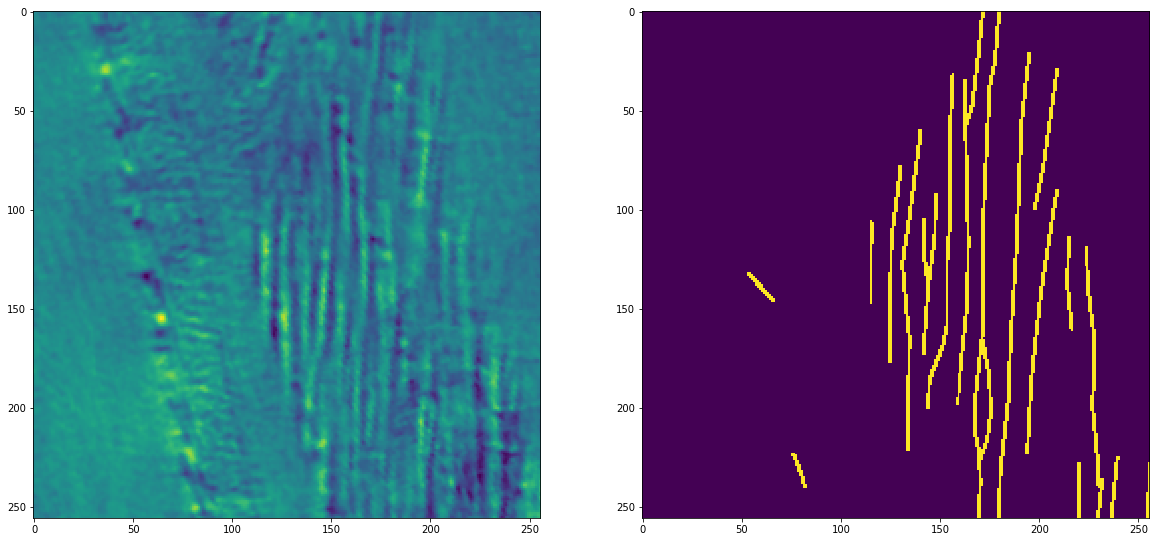

In [10]:
id = 64
#print(X_data[id].shape, L_data[id])
fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(20,20))
axarr[0, 0].imshow(X_data[id][:,:,0])
axarr[0, 1].imshow(Y_data[id][:,:,0])
plt.show()

# Save to [quilt](https://quiltdata.com/)

This will make it a bit easier for anyone to reproduce the output data from this notebook without going through all the steps above :P

In [11]:
import quilt

In [12]:
quilt.generate(directory="model")

Generated build-file model/build.yml.


In [13]:
quilt.login()

Launching a web browser...
If that didn't work, please visit the following URL: https://pkg.quiltdata.com/login
Failed to launch the browser: [Errno 2] No such file or directory: 'xdg-open': 'xdg-open'

Enter the code from the webpage: 1dHqnlTfw3kEmt1DsIq2rZXgtbieIV


In [14]:
quilt.build(package='weiji14/nz_space_challenge', path='model/build.yml')

Inferring 'transform: id' for README.md
Registering model/README.md...
Inferring 'transform: id' for train/X_data.npy
Registering model/train/X_data.npy...
Inferring 'transform: id' for train/Y_data.npy
Registering model/train/Y_data.npy...
Built weiji14/nz_space_challenge successfully.


In [15]:
quilt.push(package='weiji14/nz_space_challenge', is_public=True)

  0%|          | 0.00/230M [00:00<?, ?B/s]

Fetching upload URLs from the registry...
Uploading 3 fragments (229639901 bytes before compression)...


100%|██████████| 230M/230M [00:00<00:00, 416MB/s] 


Fragment 2b5d73a191bcc8b98c58c2b13e2c532fe1ffe05aa856668861ac67793d7dbe2a already uploaded; skipping.
Fragment 0c7f28d5ef74da0b90618d57ded1e278217ec73d0a478412b03798bd4202c53e already uploaded; skipping.
Uploading package metadata...
Updating the 'latest' tag...
Push complete. weiji14/nz_space_challenge is live:
https://quiltdata.com/package/weiji14/nz_space_challenge
